## Installs

In [ ]:
%%capture
!apt install python-opengl # Python binding to OpenGL and related APIs
!pip install pyglet==1.5.1 
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
# !pip install ale-py==0.7.4   # To overcome an issue with Gym (https://github.com/DLR-RM/stable-baselines3/issues/875)
# https://stackoverflow.com/questions/69442971/error-in-importing-environment-openai-gym
!pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 18.2 MB/s 
     |████████████████████████████████| 1.6 MB 54.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616825 sha256=f5a8a0adc6f7ff5e5345b592496ae5f1657cee9a265f06d7277b46c570b4c268
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=fece20b0939f043542345c6f7fa066dc68d9b29af80441aae9a2d73e4320041d
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-license
  Attempting uninstall: gym
    Found existing installati

## Imports

In [ ]:
import torch
import numpy as np
import cv2

import gym

## Inspect the Environment

In [ ]:
ENV_NAME = "BreakoutNoFrameskip-v4"
env = gym.make(ENV_NAME)

In [ ]:
env.observation_space.shape

(210, 160, 3)

In [ ]:
env.action_space.n, env.action_space.sample()

(4, 1)

In [ ]:
obs = env.reset()

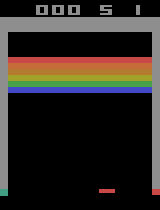

In [ ]:
from IPython.display import display
from PIL import Image, ImageOps

image = Image.fromarray(obs, mode="RGB")
display(image)

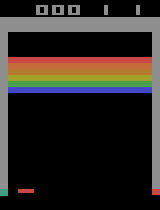

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
from IPython.display import clear_output

rews = []
for i in range(1000):
  obs, rew, done, info = env.step(env.action_space.sample())
  clear_output(wait=True)
  display(Image.fromarray(obs, mode="RGB"))
  rews.append(rew)
  if done:
    env.reset()

print(rews[-20:])

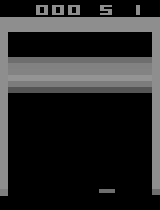

In [ ]:
# Convert to Grayscale
grayscale_image = ImageOps.grayscale(image)
grayscale_image

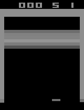

In [ ]:
# Downsampling
scaled_image = grayscale_image.resize((84, 110))
scaled_image

(84, 84)


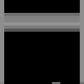

In [ ]:
# Crop 84 x 84 game area
cropping_area = (0, 17, 0, 9)
cropped_image = ImageOps.crop(scaled_image, cropping_area)
print(cropped_image.size)
cropped_image

## HyperParameters

In [ ]:
SEED = 0
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-4
NUM_FRAMES = 4
TRAIN_FREQ = 4
UPDATE_TARGET_Q_FREQ = 1000
TOTAL_TIMESTEPS = 1e6
EPSILON_START = 1
EPSILON_END = 0.01
EPSILON_DROP_FRACTION = 0.1 # fraction of total timesteps to reduce epsilon, 1e6th frame
TRAINING_STARTS = 1e5
BATCH_SIZE = 32
GAMMA = 0.99
REPLAY_BUFFER_LENGTH = 1e5
LOG_EPISODE_FREQ = 25
FRAME_SKIP = 4
NO_OP_MAX = 30  # TODO: max no of 'do nothing' actions to be performed by an agent at the start of an episode

## GPU UTILITIES

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

device

device(type='cuda')

## Q-Network

In [ ]:
import torch.nn as nn

model = nn.Sequential(nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(8,8), stride=4),
                      nn.ReLU(),
                      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4,4), stride=2),
                      nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(2592, 256),
                      nn.Linear(256, 4)).to(device)


model_opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

## DQN Algorithm

### Preprocessing Function

In [ ]:
def preprocess_sequence(seq, n_frames=NUM_FRAMES):
  if len(seq) < n_frames:
    [seq.append(seq[-1]) for _ in range(n_frames-len(seq))]

  res = []
  for i in range(-n_frames, 0):
    arr = seq[i]
    img = Image.fromarray(arr)
    img = ImageOps.grayscale(img)
    img = img.resize((84, 110))
    img = ImageOps.crop(img, (0, 17, 0, 9))
    res.append(np.asarray(img)/255.0)iwiooqowowqwqwqwqwq
    # del arr
    # del img
  return np.array(res)

In [ ]:
seq = []
for i in range(1000):
  obs, rew, done, info = env.step(env.action_space.sample())
  seq.append(obs)
  if done:
    env.reset()

input = torch.tensor(preprocess_sequence(seq, NUM_FRAMES), dtype=torch.float32)
input.shape

torch.Size([4, 84, 84])

In [ ]:
model(input.unsqueeze(0).to(device)).shape

torch.Size([1, 4])

### Gradient Descent

In [ ]:
import torch.nn.functional as F

def fit(model, opt, input, target, loss_fn=F.huber_loss, grad_clip=None):
  out = model(input)
  pred_val, _ = torch.max(out, dim=1)
  loss = loss_fn(pred_val, target)

  # Compute the gradient
  loss.backward()

  # Clip Gradient
  if grad_clip:
    nn.utils.clip_grad_value_(model.parameters(), grad_clip)

  # Perform a gradient descent step
  opt.step()
  opt.zero_grad()

  return loss.item()

### Greedy, Epsilon-Greedy Policy

In [ ]:
def greedy_policy(model, obs):
    return torch.argmax(model(obs.unsqueeze(0)), dim=1)

def epsilon_greedy_policy(model, obs, epsilon):
  if np.random.uniform() < epsilon:
    return env.action_space.sample()
  else:
    return torch.argmax(model(obs.unsqueeze(0)), dim=1)

### Main Algorithm

In [ ]:
def append_to_buffer(buffer, timestep, data, max_size):
  if(len(buffer) >= max_size):
    buffer[int(timestep % max_size)] = data
  else:
    buffer.append(data)

In [ ]:
import copy
import random
from collections import deque
import sys
import gc
import psutil

# Initialize replay buffer
replay_buffer = deque()

# Initialize target_q_network
target_q = copy.deepcopy(model)

timestep = 0

episode_number = 0
episode_returns = []
episode_mean_losses = []

while True:
  obs = env.reset()
  sequence = deque()
  sequence.append(obs)
  # Wrapper: Raw Observation Preprocessing
  preprocessed = preprocess_sequence(sequence) # Let preprocess scale [0,255] to [0,1]

  episode_return = 0
  losses = []

  done = False
  while not done:
    epsilon = EPSILON_START - (EPSILON_START - EPSILON_END)*(timestep/(TOTAL_TIMESTEPS*EPSILON_DROP_FRACTION))
    epsilon = max(epsilon, EPSILON_END)
    action = epsilon_greedy_policy(model, torch.tensor(preprocessed, dtype=torch.float32, device=device), epsilon)

    # Take action and store transition in replay buffer
    # Wrapper: Frameskipping
    rew = 0
    for _ in range(FRAME_SKIP or 1):
      obs, frame_rew, done, _ = env.step(action)
      rew += frame_rew
      if done: break

    # Wrapper: Reward Modification
    if rew < 0: rew = -1
    if rew > 0: rew = 1
    
    episode_return += rew
    append_to_buffer(seq, timestep, obs, NUM_FRAMES) #seq.append(obs)
    next_preprocessed_sequence = preprocess_sequence(sequence)
    transition = (preprocessed, action, rew, next_preprocessed_sequence, done)
    append_to_buffer(replay_buffer, timestep, transition, REPLAY_BUFFER_LENGTH) #replay_buffer.append(transition)
    # del preprocessed
    preprocessed = next_preprocessed_sequence

    # Increment Timestep, pop frame sequence and replay buffer
    timestep += 1
    # if len(replay_buffer) > REPLAY_BUFFER_LENGTH:
    #   del replay_buffer[0]
    # if len(sequence) > NUM_FRAMES:
    #   del sequence[0]

    # Compute Targets and Perform a Gradient descent step
    if (timestep >= TRAINING_STARTS) and not (timestep % TRAIN_FREQ):
      # Sample a mini-batch from the replay buffer
      batch = random.sample(replay_buffer, BATCH_SIZE)
      states = torch.tensor(np.array([x[0] for x in batch]), dtype=torch.float32, device=device)
      rews = torch.tensor([x[2] for x in batch], dtype=torch.float32, device=device)
      next_states = torch.tensor(np.array([x[3] for x in batch]), dtype=torch.float32, device=device)
      not_dones = torch.tensor([not x[4] for x in batch], dtype=torch.bool, device=device)

      # Compute TD targets
      td_targets = rews + not_dones*GAMMA*torch.max(target_q(next_states), dim=1)[0]

      # Perform Gradient Descent
      loss = fit(model, model_opt, states, td_targets, F.huber_loss)
      losses.append(loss)

    # Update the Target Q Network
    if not (timestep % UPDATE_TARGET_Q_FREQ):
      # del target_q
      target_q = copy.deepcopy(model)
      # gc.collect()

    if done:
      append_to_buffer(episode_returns, episode_number, episode_return, LOG_EPISODE_FREQ)
      # episode_returns.append(episode_return)
      append_to_buffer(episode_mean_losses, episode_number, np.mean(losses), LOG_EPISODE_FREQ)
      # episode_mean_losses.append(np.mean(losses))
      episode_number += 1

      if not (episode_number % LOG_EPISODE_FREQ):
        print(f"Episode [{episode_number}] Mean Return: {np.mean(episode_returns):.2f} Mean Loss: {np.mean(episode_mean_losses):.2f} Timestep: {timestep} Epsilon: {epsilon:.2f}")

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode [25] Mean Return: 1.16 Mean Loss: nan Timestep: 4534 Epsilon: 0.96
Episode [50] Mean Return: 0.92 Mean Loss: nan Timestep: 8833 Epsilon: 0.91
Episode [75] Mean Return: 1.28 Mean Loss: nan Timestep: 13596 Epsilon: 0.87
Episode [100] Mean Return: 0.84 Mean Loss: nan Timestep: 17962 Epsilon: 0.82
Episode [125] Mean Return: 1.28 Mean Loss: nan Timestep: 22805 Epsilon: 0.77
Episode [150] Mean Return: 1.04 Mean Loss: nan Timestep: 27352 Epsilon: 0.73
Episode [175] Mean Return: 0.92 Mean Loss: nan Timestep: 31863 Epsilon: 0.68
Episode [200] Mean Return: 0.8 Mean Loss: nan Timestep: 36327 Epsilon: 0.64
Episode [225] Mean Return: 1.2 Mean Loss: nan Timestep: 41148 Epsilon: 0.59
Episode [250] Mean Return: 1.08 Mean Loss: nan Timestep: 46090 Epsilon: 0.54
Episode [275] Mean Return: 0.72 Mean Loss: nan Timestep: 50643 Epsilon: 0.50
Episode [300] Mean Return: 0.8 Mean Loss: nan Timestep: 55473 Epsilon: 0.45
Episode [325] Mean Return: 0.72 Mean Loss: nan Timestep: 60163 Epsilon: 0.40
Episode

KeyboardInterrupt: ignored

In [ ]:
# https://imageio.readthedocs.io/en/stable/examples.html#writing-videos-with-ffmpeg-and-vaapi
# EP 110 40.7
# EP 170 48.3
# EP 230 55.5
# EP 300 63.1